In [1]:
from dataget import data
import tfinterface as ti
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz

In [2]:
dataset = data("mnist").get()

traning_set = dataset.complete_set

traning_set.df = traning_set.df.sample(frac=1)

In [3]:
class Discriminator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        print("##########################")
        print("## Discriminator")
        print("##########################")
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        net = ti.layers.conv2d_batch_norm(net, 16, [5, 5], strides = 2, activation = tf.nn.elu, padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 32, [3, 3], strides = 2, activation = tf.nn.elu, padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 64, [3, 3], strides = 2, activation = tf.nn.elu, padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 128, [2, 2], strides = 2, activation = tf.nn.elu, padding = "same", batch_norm = dict(training = training)); print(net)

        
        net = tf.contrib.layers.flatten(net); print(net)
        
        net = ti.layers.dense_batch_norm(net, 64, activation = tf.nn.elu, batch_norm = dict(training = training)); print(net)
        net = logits = tf.layers.dense(net, 1, activation = None); print(net)
#         net = tf.nn.sigmoid(net); print(net)
        
        return logits
    
    
class Generator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        print("##########################")
        print("## Generator")
        print("##########################")
        
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        net = inputs["embedding"]; print(net)
        
        net = ti.layers.conv2d_transpose_batch_norm(net, 512, [2, 2], strides = 1, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 256, [3, 3], strides = 2, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 128, [3, 3], strides = 2, activation = tf.nn.elu, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 1, [3, 3], strides = 2, activation = tf.nn.tanh, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        
        net = (net + 1.0) / 2.0
        
        
        return net

In [4]:

inputs = dict(
    image = tf.layers.Input(shape=(28, 28, 1)),
    embedding = tf.layers.Input(shape=(2, 2, 25)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

D = Discriminator(name = "discriminator")
G = Generator(name = "generator")

d = D(inputs)
print("")
g = G(inputs)

##########################
## Discriminator
##########################
Tensor("input_layer_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm/Elu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_1/Elu:0", shape=(?, 6, 6, 32), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_2/Elu:0", shape=(?, 2, 2, 64), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_3/Elu:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("discriminator/Flatten/flatten/Reshape:0", shape=(?, 128), dtype=float32)
Tensor("discriminator/DenseBatchNorm/Elu:0", shape=(?, 64), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)

##########################
## Generator
##########################
Tensor("input_layer_2:0", shape=(?, 2, 2, 25), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm/Elu:0", shape=(?, 3, 3, 512), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_1/Elu:0", shape=(?, 7, 7, 256), dtype=float

(28, 28)


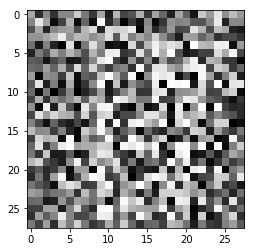

In [7]:
with tf.Session() as sess:

    sample = np.random.uniform(size=(1, 2, 2, 25))
    embedding = inputs["embedding"]

    sess.run(tf.global_variables_initializer())

    img = sess.run(g, feed_dict={embedding: sample})

    img = np.squeeze(img * 255).astype(np.uint8)

    print(img.shape)
    plt.imshow(img, cmap="gray")
    plt.show()

In [10]:
class IteratorHook(tf.train.SessionRunHook):
        
    def after_create_session(self, session, coord):
        self.sess = session
    
    def before_run(self, context):
        self.sess.run(self.iterator.initializer)


       
ds = tf.data.Dataset.from_tensor_slices(tf.random_normal([5, 10]))
ds = ds.repeat(10)
# ds = ds.batch(5)

it = ds.make_initializable_iterator()
rnd = it.get_next()

it_hook = IteratorHook()
it_hook.iterator = it


with tf.train.MonitoredSession(hooks=[it_hook]) as sess:
    for i in range(10):
        print(sess.run(rnd))


[-0.80438405  0.17998689  0.86870277  0.25770384 -0.79762101  1.79292715
 -0.4907597   0.42706612 -1.97899985 -1.07301307]
[ 0.24800056 -0.79969704 -0.43454173 -0.62807518 -0.18873358  0.06134527
  0.53475362  1.59782529 -0.36821562  0.16880761]
[ 0.35414001  1.09281123  0.76988405 -1.26530111 -0.74630004 -1.1514312
  0.15728365 -1.23153365  1.52408457  0.02062935]
[ 0.23047844  0.541161    0.70365369 -1.12630451 -0.31736249  0.18063359
 -1.18972969  0.6422689  -0.27404967  1.02846265]
[ 0.58901626 -0.62731767 -0.32021815  2.16040683  0.67771691  0.27794921
 -0.0030562   1.98268807  0.3053109   0.0378434 ]
[-1.5147922   0.87447494 -0.08610281 -0.22825362  0.54801422  0.25722119
  1.70355248 -0.72932774 -0.48296347 -1.93788028]
[-0.07331083  0.2724714  -0.28440446 -1.91525364 -0.38384095  0.9620108
 -2.55129218 -0.80453628  2.04576969  1.38955617]
[-1.99117982  0.88143957 -1.0284071   1.09301054 -0.20038006 -0.77247131
 -1.58456731  0.23823227 -0.77203387 -1.57239795]
[-1.55924702 -0.69

In [11]:
class IteratorHook(tf.train.SessionRunHook):
        
    def after_create_session(self, session, coord):
        self.sess = session
    
    def before_run(self, context):
        self.sess.run(self.iterator.initializer)

def get_train_input_fn(df, img_shape = [28, 28], embeddings_shape = [2, 2, 25], epochs = 10, batch_size = 64):
    hook = IteratorHook()
    
    def train_input_fn():

        def parse(filename):

            img = tf.read_file(filename)
            img = tf.image.decode_jpeg(img, channels = 1)
            img = tf.image.resize_images(img, img_shape)

            return img

        def embeddings():
            for i in range(len(df)):
                yield np.random.normal(size=embeddings_shape)

        
        # ds_images
        ds_images = tf.data.Dataset.from_tensor_slices(df.filename.as_matrix())
        ds_images = ds_images.map(parse)
        ds_images = ds_images.shuffle(buffer_size = 1000)
        ds_images = ds_images.batch(batch_size)
        
        #ds_embeddings
        ds_embeddings = tf.data.Dataset.from_tensors(tf.random_normal([batch_size] + embeddings_shape))
        
        # zip
        ds = tf.data.Dataset.zip((ds_images, ds_embeddings))
        
        # repeat
        ds = ds.repeat(epochs)

        # get iterator
        iterator = ds.make_initializable_iterator()
        image, embedding = iterator.get_next()
        
        # set iterator
        hook.iterator = iterator

        return dict(image = image, embedding = embedding), None
    
    return train_input_fn, hook

{'image': <tf.Tensor 'IteratorGetNext_2:0' shape=(?, 28, 28, 1) dtype=float32>, 'embedding': <tf.Tensor 'IteratorGetNext_2:1' shape=(20, 2, 2, 25) dtype=float32>}


/home/cristian/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


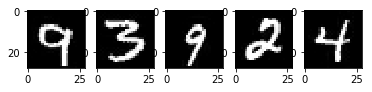

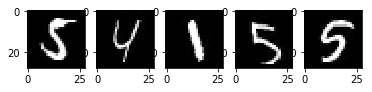

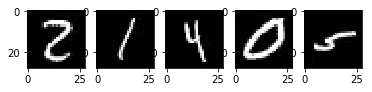

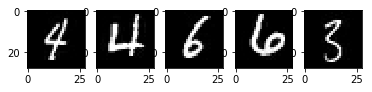

In [12]:
input_fn, it_hook = get_train_input_fn(traning_set.df, batch_size=20)

features, _ = input_fn()
image = features["image"]

print(features)

with tf.train.MonitoredSession(hooks=[it_hook]) as sess:
    
    images = sess.run(image)

    for images in cz.partition(5, images):

        fig, axes = plt.subplots(1, 5, subplot_kw=dict())

        for i, img in enumerate(images):


            img = np.squeeze(img).astype(np.uint8)

            axes[i].imshow(img, cmap="gray")

        fig.show()

    plt.show()

In [13]:
def model_fn(features, labels, mode, params):
    
    image = features["image"]
    embedding = features["embedding"]
    
    D = Discriminator(name = "discriminator")
    G = Generator(name = "generator")
    
    # generator predictions
    fake_image = G(dict(
        embedding = embedding,
        mode = mode,
    ))
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = fake_image
        )
    
    
    
    # d_loss_real
    d_logits_real = D(dict(
        image = image,
        mode = mode,
    ))
    
    is_real = tf.ones_like(real_d_logits, dtype=tf.float32)
    
    d_loss_real = tf.losses.sigmoid_cross_entropy(is_real, d_logits_real)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    # d_loss_fake
    d_logits_fake = D(dict(
        image = fake_image,
        mode = mode,
    ))
    
    is_fake = tf.zeros_like(d_logits_fake, dtype=tf.float32)
    
    d_loss_fake = tf.losses.sigmoid_cross_entropy(is_fake, d_logits_fake)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    # d_loss
    d_loss = d_loss_real + d_loss_fake
    
    # g_loss
    g_loss = tf.losses.sigmoid_cross_entropy(is_real, d_logits_fake)
    
    # global loss
    loss = g_loss + d_loss
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = net,
            loss = loss
        )
    
    
    #updates
    d_update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(
        d_loss,
        global_step = params["global_step"],
        var_list = D.get_variables(),
    )
    
    g_update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(
        g_loss,
        global_step = params["global_step"],
        var_list = G.get_variables(),
    )
    
    # general update with batch_norm updates
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        update = tf.group(d_update, g_update)
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = net,
        loss = loss,
        train_op = update
    )

In [14]:
global_step = tf.train.get_global_step()

model_spec = model_fn(features, None, tf.estimator.ModeKeys.PREDICT, params = dict(
    global_step = global_step,
    learning_rate = 0.001
))

##########################
## Generator
##########################
Tensor("IteratorGetNext_2:1", shape=(20, 2, 2, 25), dtype=float32)
Tensor("generator_1/Conv2dTransposeBatchNorm/Elu:0", shape=(20, 3, 3, 512), dtype=float32)
Tensor("generator_1/Conv2dTransposeBatchNorm_1/Elu:0", shape=(20, 7, 7, 256), dtype=float32)
Tensor("generator_1/Conv2dTransposeBatchNorm_2/Elu:0", shape=(20, 14, 14, 128), dtype=float32)
Tensor("generator_1/Conv2dTransposeBatchNorm_3/Tanh:0", shape=(20, 28, 28, 1), dtype=float32)


In [18]:
global_variables_initializer = tf.global_variables_initializer()

with tf.train.MonitoredSession(hooks=[it_hook]) as sess:
    sess.run(global_variables_initializer)
    preds = sess.run(model_spec.predictions)

In [20]:
model = tf.estimator.Estimator()

(20, 28, 28, 1)